In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tonof\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../Data/compressed_okcupid.csv').dropna(subset=['essay0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18831 entries, 0 to 18830
Data columns (total 14 columns):
Unnamed: 0        18831 non-null int64
age               18831 non-null int64
body_type         18831 non-null object
education         18831 non-null object
essay0            18831 non-null object
essay9            18831 non-null object
ethnicity         18831 non-null object
height            18831 non-null float64
edu               18831 non-null object
fit               18831 non-null object
race_ethnicity    18831 non-null object
height_group      18831 non-null object
long_words        18831 non-null int64
flesch            18831 non-null float64
dtypes: float64(2), int64(3), object(9)
memory usage: 2.2+ MB


In [4]:
data = df['essay0']

In [5]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()),
                              tags=[str(i)]) for i, _d in enumerate(df['essay0'])]

In [6]:
from gensim.models.doc2vec import Doc2Vec

max_epochs = 50
vec_size = 50
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("dv_50.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
Model Saved


In [7]:
#from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("dv_50.model")
#to find the vector of a document which is not in training data
#test_data = word_tokenize("I love chatbots".lower())
#v1 = model.infer_vector(test_data)
#print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('0')
print(similar_doc)

[('13724', 0.6265544295310974), ('409', 0.6243237257003784), ('7897', 0.6186724901199341), ('3692', 0.6128042340278625), ('8832', 0.5994724035263062), ('9268', 0.5985327959060669), ('9418', 0.5984000563621521), ('9424', 0.5952227711677551), ('3035', 0.5951392650604248), ('3408', 0.5933350324630737)]


In [8]:
model.docvecs.vectors_docs.shape
type(model.docvecs.vectors_docs)

numpy.ndarray

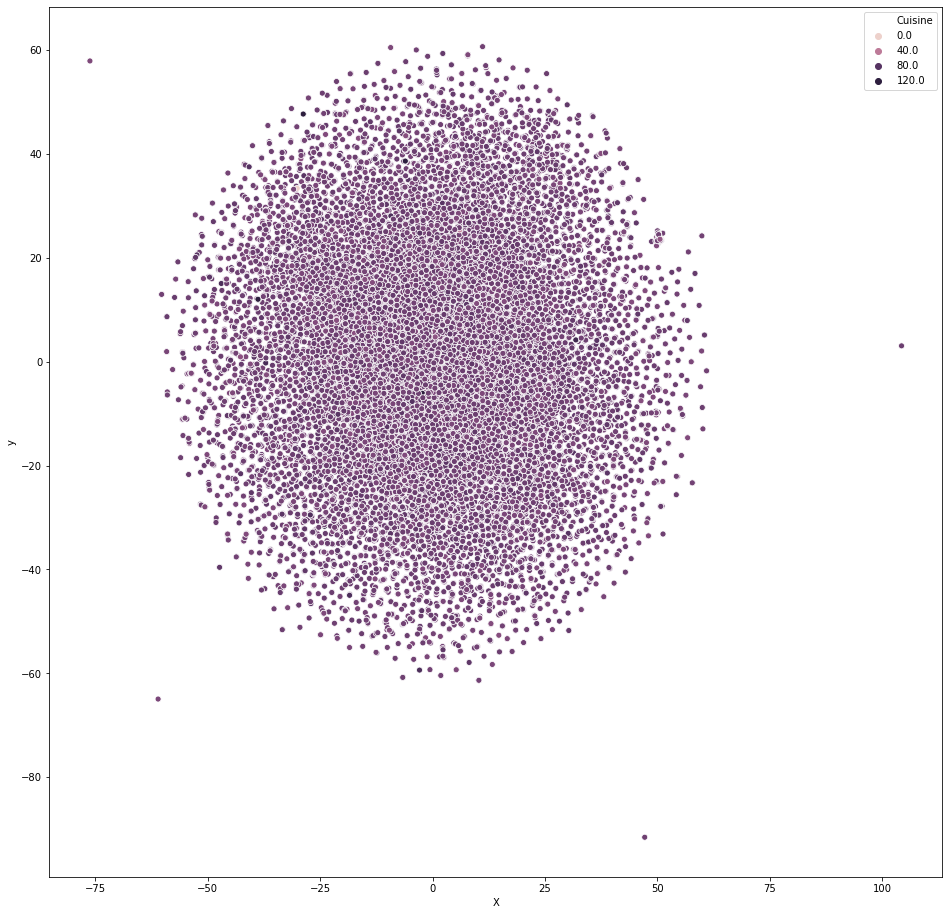

In [9]:
#Visualize TSNE with doc2vec
from sklearn.manifold import TSNE
def doc2vec_tsne_plot(doc_model, labels):

    tokens = []
    for i in range(len(doc_model.docvecs.vectors_docs)):
        tokens.append(doc_model.docvecs.vectors_docs[i])

    # Reduce 100 dimensional vectors down into 2-dimensional space so that we can see them
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    X = [doc[0] for doc in new_values]
    y = [doc[1] for doc in new_values]

    # Combine data into DataFrame, so that we plot it easily using Seaborn
    df = pd.DataFrame({'X':X, 'y':y, 'Cuisine':labels})
    plt.figure(figsize=(16, 16))
    sns.scatterplot(x="X", y="y", hue="Cuisine", data=df)
    return

doc2vec_tsne_plot(model, df['height'])

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = model.docvecs.vectors_docs
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

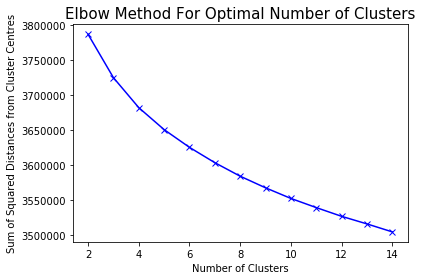

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances from Cluster Centres')
plt.title('Elbow Method For Optimal Number of Clusters', fontsize=15)
plt.savefig('Elbow_Plot.png', bbox_inches='tight')


In [12]:
num_clusters = 4
num_seeds = 4
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404'
}
pca_num_components = 2
#texts_list = df['essay0']
# calculate tf-idf of texts
#tf_idf_vectorizer = TfidfVectorizer(analyzer="word", use_idf=True,
                                    #smooth_idf=True, ngram_range=(2, 3))
#tf_idf_matrix = tf_idf_vectorizer.fit_transform(texts_list)

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

X = model.docvecs.vectors_docs
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
labels = clustering_model.fit_predict(reduced_data)

In [13]:
pca_num_components = 2
X = model.docvecs.vectors_docs
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)


In [16]:
# there appears to be no column named 'clust_label' in df
#df[df['clust_label']==1]['essay0']

KeyError: 'clust_label'

In [17]:
from sklearn.manifold import TSNE
# Creating and fitting the tsne model to the document embeddings
tsne_model = TSNE(early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(model.docvecs.vectors_docs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18831 samples in 0.061s...
[t-SNE] Computed neighbors for 18831 samples in 38.920s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18831
[t-SNE] Computed conditional probabilities for sample 2000 / 18831
[t-SNE] Computed conditional probabilities for sample 3000 / 18831
[t-SNE] Computed conditional probabilities for sample 4000 / 18831
[t-SNE] Computed conditional probabilities for sample 5000 / 18831
[t-SNE] Computed conditional probabilities for sample 6000 / 18831
[t-SNE] Computed conditional probabilities for sample 7000 / 18831
[t-SNE] Computed conditional probabilities for sample 8000 / 18831
[t-SNE] Computed conditional probabilities for sample 9000 / 18831
[t-SNE] Computed conditional probabilities for sample 10000 / 18831
[t-SNE] Computed conditional probabilities for sample 11000 / 18831
[t-SNE] Computed conditional probabilities for sample 12000 / 18831
[t-SNE] Computed conditional probabilities for sa

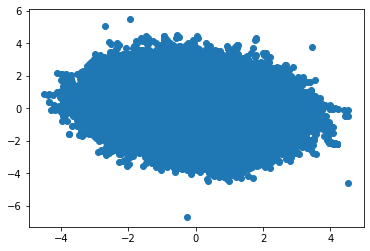

<Figure size 432x288 with 0 Axes>

In [18]:
plt.scatter(tsne_d2v [:, 0], tsne_d2v [:, 1])
plt.show()
plt.savefig('TSNE_blob.png', bbox_inches='tight')

In [30]:
output = pd.DataFrame(model.docvecs.vectors_docs)
output.to_csv("../Data/doc2vec_results.csv")
output

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-3.041887,-1.893209,-3.074374,3.758997,2.263446,-2.384883,1.390263,0.706362,-6.069676,-1.475603,...,2.477055,3.278381,0.904463,1.102665,0.768490,1.860852,2.340014,-0.354107,-1.889057,1.098765
1,-1.070138,-1.373656,2.280668,-0.909384,-0.505649,0.463939,0.543563,-1.638621,-3.332971,-2.048158,...,0.907550,2.245790,-4.262563,1.617618,3.544868,1.684934,0.147928,0.456568,-1.097310,-0.279348
2,0.454095,0.132624,0.968346,1.123773,5.143617,-2.833173,3.251486,1.344957,-0.337086,-1.342130,...,1.483345,2.659227,-4.590605,2.802964,-1.413413,2.760384,5.639993,-0.418147,-1.092230,1.019542
3,-1.703150,-3.020601,-2.970192,-1.283624,-0.743413,1.885488,-2.999677,1.178905,-4.547679,-5.228343,...,-3.963870,-0.010448,-3.575478,0.473029,1.684729,0.209506,2.205954,-1.017996,1.816112,1.470100
4,0.454678,-0.328345,1.475412,1.314191,-2.275458,0.626898,-1.833220,-1.567218,-1.896069,-1.076299,...,0.708227,0.283030,-2.284160,4.514041,1.939193,0.035374,2.720823,2.130446,2.307705,0.781379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,-1.194371,-2.463360,0.016593,3.885833,-1.379347,1.780055,0.782711,-0.511826,-2.663905,2.051974,...,1.179302,2.486935,-1.939109,2.290070,1.879003,2.878888,-0.384010,1.141451,-1.195931,-0.687128
18827,2.339970,0.030192,1.382285,5.433922,2.192838,-0.691201,-4.165049,0.193415,-2.666047,-1.224164,...,-0.769532,4.492056,-5.940155,1.030465,2.956730,0.947368,0.075826,0.109504,1.498118,4.329016
18828,-0.720579,-2.475874,1.975166,0.705376,-2.101328,1.825349,-1.579317,-1.910452,-3.559072,-1.532123,...,1.899417,2.080770,-2.763085,2.558170,0.356473,-0.289595,2.531146,0.337330,2.643312,1.079801
18829,-2.826079,-0.118038,4.615818,1.205481,-3.155207,-0.154660,1.039351,-1.317657,-1.984071,-2.972950,...,0.927432,3.911177,-4.556782,0.252527,-0.876225,-0.286455,-0.569511,0.019703,-1.132649,-2.796735
